In [110]:
%pylab inline
from importlib import reload
import multigpu
reload(multigpu)
import utils
reload(utils)
import numpy as np
import opt
reload(opt)
from opt import trainAndEvaluatePrimalModel, trainAndEvaluateDualModel, computeRBFGramMatrix, computeDistanceMatrix
from sklearn import metrics
import sys
import seaborn as sns
import pandas as pd
import time
from numba import jit


Populating the interactive namespace from numpy and matplotlib


In [111]:
ARE_YOU_SURE = False

def switch_output_to_notebook():
    sys.stdout = notebook_stdout
    sys.stderr = notebook_stdout

def switch_output_to_terminal():
    sys.stdout = terminal_stdout
    sys.stderr = terminal_stderr

    

In [108]:
if (ARE_YOU_SURE):
    print("DELETING ALL RESULTS YOU HAVE 10 seconds to ctrl-c")
    notebook_stdout = sys.stdout
    notebook_stderr = sys.stderr
    terminal_stdout = open('/dev/stdout', 'w')
    terminal_stderr = open('/dev/stderr', 'w')
    time.sleep(10)
    # PUT CRITICAL CLEARING CODE HERE
    results = []
    features = []
else:
    print("YOU ARE NOT SURE YOU DUMMY")

YOU ARE NOT SURE YOU DUMMY


In [ ]:
# should take around 10 minutes
%time train_df = pd.read_csv("full_genomics/deepsea_full_train.csv")
%time test_df = pd.read_csv("full_genomics/deepsea_full_test.csv")

In [96]:
%time eval_df = pd.read_csv("full_genomics/deepsea_full_eval.csv")

tfs = list(map(lambda x: x.split("|")[0], list(train_df.columns[1:])))
cell_types = list(map(lambda x: x.split("|")[1], list(train_df.columns[1:])))

CPU times: user 948 ms, sys: 32 ms, total: 980 ms
Wall time: 975 ms


In [213]:
DATASET = "GM12878|Egr-1|None"
SEED = 0
SEQ_SIZE = 300
NUM_FEATURES = 8192
GAMMA = 1.0
KMER_SIZE = 8
FEATS_TO_USE = 16384
LAMBDA = 1e

In [125]:
y_train_full = train_df[DATASET].as_matrix()
y_eval = eval_df[DATASET].as_matrix()
y_test = test_df[DATASET].as_matrix()
all_seqs_train = train_df["Sequence"]
all_seqs_test = test_df["Sequence"]
all_seqs_eval = eval_df["Sequence"]

In [198]:
np.random.seed(0)
y_train_pos = y_train_full[y_train_full == 1]
y_train_neg_locs = np.random.choice(np.where(y_train_full == 0)[0], y_train_pos.shape[0], replace=False)
y_train = np.hstack((y_train_pos, y_train_full[y_train_neg_locs]))
seqs_train = pd.concat((all_seqs_train[y_train_full == 1], all_seqs_train[y_train_neg_locs]))


In [202]:
x_seqs_train = seqs_train.str.slice(500 - SEQ_SIZE//2, 500 + SEQ_SIZE//2).tolist()
x_seqs_eval = all_seqs_eval.str.slice(500 - SEQ_SIZE//2, 500 + SEQ_SIZE//2).tolist()
x_seqs_test = all_seqs_test.str.slice(500 - SEQ_SIZE//2, 500 + SEQ_SIZE//2).tolist()

X_train = utils.convertSeqToMatrix(x_seqs_train)
X_eval = utils.convertSeqToMatrix(x_seqs_eval)
X_test = utils.convertSeqToMatrix(x_seqs_test)

In [205]:
W = np.random.randn(NUM_FEATURES,KMER_SIZE*4) * GAMMA
%time X_lift_train_gpu = multigpu.conv_multi_gpu(X_train, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="train", loc="/mnt/tmp")
%time X_lift_eval_gpu = multigpu.conv_multi_gpu(X_eval, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="val", loc="/mnt/tmp")

Using gpu device 7: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
Using gpu device 2: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using gpu device 13: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you

gpu2 512 (60508, 1024)
gpu7 512 (60508, 1024)
gpu13 512 (60508, 1024)
gpu10 512 (60508, 1024)
gpu12 512 (60508, 1024)
gpu0 512 (60508, 1024)
gpu5 512 (60508, 1024)
gpu4 512 (60508, 1024)
gpu3 512 (60508, 1024)
gpu15 512 (60508, 1024)
gpu1 512 (60508, 1024)
gpu11 512 (60508, 1024)
gpu6 512 (60508, 1024)
gpu14 512 (60508, 1024)
1
1
gpu2 Feature Batch  0
gpu7 Feature Batch  0
gpu2 Data Batch  0
gpu7 Data Batch  0
1
gpu13 Feature Batch  0
gpu13 Data Batch  0
1
1
gpu12 Feature Batch  0
gpu10 Feature Batch  0
gpu12 Data Batch  0
gpu10 Data Batch  0
1
1
gpu0 Feature Batch  0
gpu5 Feature Batch  0
gpu5 Data Batch  0
gpu0 Data Batch  0
1
1
gpu15 Feature Batch  0
gpu14 Feature Batch  0
gpu14 Data Batch  0
gpu15 Data Batch  0
1
1
1
1
1
gpu4 Feature Batch  0
gpu11 Feature Batch  0
gpu3 Feature Batch  0
gpu6 Feature Batch  0
gpu1 Feature Batch  0
gpu4 Data Batch  0
gpu11 Data Batch  0
gpu3 Data Batch  0
gpu6 Data Batch  0
gpu1 Data Batch  0


Using gpu device 9: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
Using gpu device 8: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


gpu8 512 (60508, 1024)
gpu9 512 (60508, 1024)
1
1
gpu9 Feature Batch  0
gpu8 Feature Batch  0
gpu9 Data Batch  0
gpu8 Data Batch  0
gpu7 Data Batch  1
gpu0 Data Batch  1
gpu2 Data Batch  1
gpu11 Data Batch  1
gpu10 Data Batch  1
gpu14 Data Batch  1
gpu6 Data Batch  1
gpu15 Data Batch  1
gpu2 Data Batch  2
gpu13 Data Batch  1
gpu7 Data Batch  2
gpu0 Data Batch  2
gpu1 Data Batch  1
gpu11 Data Batch  2
gpu15 Data Batch  2
gpu10 Data Batch  2
gpu14 Data Batch  2
gpu6 Data Batch  2
gpu3 Data Batch  1
gpu9 Data Batch  1
gpu12 Data Batch  1
gpu5 Data Batch  1
gpu8 Data Batch  1
gpu4 Data Batch  1
gpu11 Data Batch  3
gpu2 Data Batch  3
gpu13 Data Batch  2
gpu10 Data Batch  3
gpu7 Data Batch  3
gpu15 Data Batch  3
gpu0 Data Batch  3
gpu1 Data Batch  2
gpu5 Data Batch  2
gpu9 Data Batch  2
gpu14 Data Batch  3
gpu6 Data Batch  3
gpu12 Data Batch  2
gpu3 Data Batch  2
gpu8 Data Batch  2
gpu4 Data Batch  2
gpu11 Data Batch  4
gpu2 Data Batch  4
gpu15 Data Batch  4
gpu13 Data Batch  3
gpu7 Data Bat

Using gpu device 10: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using gpu device 3: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using gpu device 2: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you

gpu10 512 (8000, 1024)
1
gpu10 Feature Batch  0
gpu10 Data Batch  0
gpu3 512 (8000, 1024)
gpu2 512 (8000, 1024)
gpu15 512 (8000, 1024)
gpu13 512 (8000, 1024)
gpu6 512 (8000, 1024)
gpu0 512 (8000, 1024)
1
1
1
gpu15 Feature Batch  0
gpu2 Feature Batch  0
gpu3 Feature Batch  0
gpu2 Data Batch  0
gpu15 Data Batch  0
gpu3 Data Batch  0
gpu14 512 (8000, 1024)
gpu8 512 (8000, 1024)
gpu7 512 (8000, 1024)
1
gpu13 Feature Batch  0
gpu13 Data Batch  0
1
gpu6 Feature Batch  0
gpu6 Data Batch  0
1
gpu0 Feature Batch  0
gpu9 512 (8000, 1024)
gpu0 Data Batch  0
gpu12 512 (8000, 1024)
gpu4 512 (8000, 1024)
gpu5 512 (8000, 1024)
gpu1 512 (8000, 1024)
1
1
gpu8 Feature Batch  0
gpu7 Feature Batch  0
1
gpu7 Data Batch  0
gpu8 Data Batch  0
gpu14 Feature Batch  0
gpu14 Data Batch  0
1
1
gpu12 Feature Batch  0
gpu9 Feature Batch  0
gpu12 Data Batch  0
gpu9 Data Batch  0
1
1
gpu5 Feature Batch  0
gpu4 Feature Batch  0
gpu4 Data Batch  0
gpu5 Data Batch  0
1
gpu1 Feature Batch  0
gpu1 Data Batch  0


Using gpu device 11: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/mnt/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


gpu11 512 (8000, 1024)
1
gpu11 Feature Batch  0
gpu11 Data Batch  0
gpu9 Data Batch  1
gpu15 Data Batch  1
gpu14 Data Batch  1
gpu13 Data Batch  1
gpu8 Data Batch  1
gpu10 Data Batch  1
gpu12 Data Batch  1
gpu4 Data Batch  1
gpu2 Data Batch  1
gpu6 Data Batch  1
gpu7 Data Batch  1
gpu1 Data Batch  1
gpu3 Data Batch  1
gpu0 Data Batch  1
gpu11 Data Batch  1
gpu5 Data Batch  1
gpu9 Data Batch  2
gpu15 Data Batch  2
gpu14 Data Batch  2
gpu13 Data Batch  2
gpu8 Data Batch  2
gpu12 Data Batch  2
gpu10 Data Batch  2
gpu4 Data Batch  2
gpu7 Data Batch  2
gpu2 Data Batch  2
gpu3 Data Batch  2
gpu1 Data Batch  2
gpu6 Data Batch  2
gpu0 Data Batch  2
gpu5 Data Batch  2
gpu11 Data Batch  2
gpu9 Data Batch  3
gpu15 Data Batch  3
gpu14 Data Batch  3
gpu13 Data Batch  3
gpu8 Data Batch  3
gpu10 Data Batch  3
gpu12 Data Batch  3
gpu4 Data Batch  3
gpu7 Data Batch  3
gpu2 Data Batch  3
gpu3 Data Batch  3
gpu1 Data Batch  3
gpu6 Data Batch  3
gpu0 Data Batch  3
gpu11 Data Batch  3
gpu5 Data Batch  3
gp

(60508, 16384)
(8000, 16384)
X SHAPE  (60508, 16384)
Computing XTX
Done Computing XTX
Train acc 0.810686190256
Test acc 0.896625
Train ROC  0.896260398217
Test ROC  0.990512434643
Train AUPRC  0.889114350311
Test AUPRC  0.19275353975


/mnt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


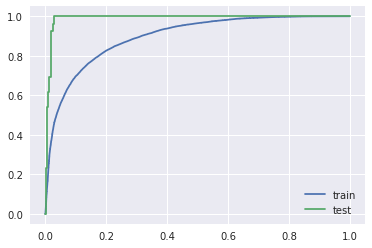

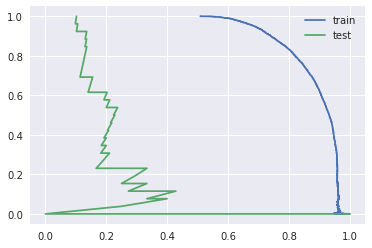

In [214]:
res = trainAndEvaluatePrimalModel(X_lift_train_gpu[:, :FEATS_TO_USE], 
                                  X_lift_eval_gpu[:, :FEATS_TO_USE],
                                  y_train, y_eval, 
                                    reg=LAMBDA)
train_roc, test_roc, train_pr_curve, test_pr_curve, train_pr_auc, test_pr_auc, yPredTrain, yPredTest = res 
train_roc_plot = plt.plot(train_roc[0], train_roc[1], label="train")
test_roc_plot = plt.plot(test_roc[0], test_roc[1], label="test")
train_roc = metrics.auc(train_roc[0], train_roc[1])
test_roc = metrics.auc(test_roc[0], test_roc[1])
plt.legend(handles=[train_roc_plot[0], test_roc_plot[0]])
plt.figure()
train_pr_curve_plot = plt.plot(train_pr_curve[0], train_pr_curve[1], label="train")
test_pr_curve_plot = plt.plot(test_pr_curve[0], test_pr_curve[1], label="test")
plt.legend(handles=[train_pr_curve_plot[0], test_pr_curve_plot[0]])
plt.figure()
print ("Train ROC ", train_roc)
print ("Test ROC ", test_roc)
print("Train AUPRC ", train_pr_auc)
print("Test AUPRC ", test_pr_auc)

In [140]:
metrics.auc(test_roc[1], test_roc[0])

0.58381084679053086